In [1]:
import os
import sys
import pandas as pd
import numpy as np

from pygus.gus.population import generate_population_allometrics

In [2]:
def percentage_change(current_value, initial_value):
    """The function to copmpute percentage change with respect to a given base value."""
    if initial_value == 0:
        return 0

    return ((current_value - initial_value) / initial_value) * 100


def compute_under_canopy_area_m2(crown_diameter):
    return pow((crown_diameter / 2), 2) * np.pi


def compute_leaf_area_index(
    dbh,
    tree_height,
    crown_depth,
    crown_diameter,
    crown_missing=0,
    shade_factor=0.85,
):
    """The function given allometrics of a tree computes its leaf, bark and plant area indices.

    Args:
        dbh: (:obj:`float`): the diameter in cm of the trunk usually measured at 1.3m from the ground.
        tree_height: (:obj:`float`): The tree height in meters.
        crown_debth: (:obj:`float`): The vertical length of tree crown in meters.
        crown_diameter: (:obj:`float`): The horizontal length (diameter) of tree crown in meters.
        crown_missing: (:obj:`float`): The percentage loss of the crown.
        shade_factor: (:obj:`float`): The percentage of sky covered by foliage and branches.

        Shade factor, is the percentage of sky covered by foliage and branches within the perimeter of individual tree crowns,
        can vary by species from about 60% to 95% when trees are in-leaf (McPherson, 1984). The value below is set according to
        Glasgow mean and needs to be updated per city or per tree.

    Returns:
        (:obj:`float`): It eturns the LAI.
    Note:
        The beta multipliers and the main equation is based on Nowak (1996).

    TODO:
        Parametrize beta multipliers.
    """
    loss = crown_missing
    th = tree_height
    cw = crown_diameter
    cd = crown_depth
    sf = shade_factor
    beta_0 = -4.3309
    beta_1 = 0.2942
    beta_2 = 0.7312
    beta_3 = 5.7217
    beta_4 = 0.0148

    # Outer surface area estimate below is based on Gacka-Grzesikiewicz (1980).
    under_canopy = compute_under_canopy_area_m2(cw)
    crown_surface = np.pi * cw * (cd + cw) / 2
    leaf_area = (1 - loss) * np.exp(
        beta_0 + beta_1 * th + beta_2 * cw + beta_3 * sf - beta_4 * crown_surface
    )
    leaf_area_index = leaf_area / under_canopy  # m^2/m^2
    return leaf_area_index  # An intuitive way to think about LAI is as the one-sided green leaf area per unit ground surface area. !!


def compute_gross_canopy_index(tree_height, crown_depth, crown_diameter):
    """The function given allometrics of a tree computes an index to account shading effect immediately underneath its canopy.

    Args:
        tree_height: (:obj:`float`): The tree height in meters.
        crown_height: (:obj:`float`): The vertical length of tree crown in meters.
        crown_width: (:obj:`float`): The horizontal length (diameter) of tree crown in meters.

    Returns:
        (:obj:`float`): returns the GCI index
    Note:
        The index is based on (Zhang et.al., 2020). It accounts for the overall immediate shading effect of a tree.
        It accounts both crown diameter (tw) and the crown base height (th - ch), the distance from the ground to the start of
        the canopy.
    """
    th = tree_height
    cw = crown_diameter
    cd = crown_depth
    crown_base_height = th - cd
    if crown_base_height < 0.1:
        crown_base_height = 0.1
    GCI = cw / crown_base_height
    return GCI  # GCI is just a ratio of crown diameter to crown base height. It is a measure of the overall immediate shading effect of a tree.


def compute_crown_volume_index(leaf_area_index, crown_canopy_index):
    """The function given computes a composite index taking into account both leaf density and canopy shape.

    Args:
        leaf_area_indext: (:obj:`float`): The index on the leaf density per the area under the canopy.
        crown_canopy_index: (:obj:`float`): The index that accounts for the geomtric shape of the canopy relevant to shading.

    Returns:
        (:obj:`float`): returns the CVI index
    Note:
        The index is adopted from (Zhang et.al., 2020).
    """
    # CVI is a composite index taking into account both leaf density and canopy shape.
    return leaf_area_index * crown_canopy_index


dT_max = 0.67
m1 = 0.1
m2 = 0.75
m4 = 0.75
m5 = 0.2
T0 = 10
T1 = 18
T2 = 26
T3 = 35
T4 = 45
T5 = 50
avg_conifer_cooling_factor = 0.66


def cooling_multiplier(T):
    if T < T0:
        return 0
    if T < T1:
        return m1 * dT_max
    if T < T2:
        return m2 * dT_max
    if T < T3:
        return dT_max
    if T < T4:
        return m4 * dT_max
    if T < T5:
        return m5 * dT_max
    return 0


# Comparing this index of the canopy, and how it changes across a timespan from A to B
# We can estimate the further cooling potential of that tree canopy in B relative to A (in degrees C)
def compute_cooling(canopy_change_cvi, T=30, species=None):
    # The CVI is a composite index taking into account both leaf density and canopy shape. The higher the CVI the greater the cooling effect.
    if species == "conifer":
        species_factor = 0.6
    elif species == "decidu":
        species_factor = 0.9
    else:
        species_factor = 1
    return species_factor * np.sqrt(canopy_change_cvi / 10) * cooling_multiplier(T)


def calculate_nth_year_CVI_and_percentage_canopy_cover(df):
    nth_CVIs = df.apply(
        lambda row: compute_crown_volume_index(
            compute_leaf_area_index(
                row["dbh"], row["height"], row["crownH"], row["crownW"]
            ),
            compute_gross_canopy_index(row["height"], row["crownH"], row["crownW"]),
        ),
        axis=1,
    )

    # Same for the coverage in year N
    canopy_cover_N = (
        df.apply(
            lambda row: compute_under_canopy_area_m2(row["crownW"]), axis=1
        ).sum()
    )
    
    return nth_CVIs, canopy_cover_N

# Parsloes Park forest
## Forest of Thanks

Area: 10000 sq meter

Density: 3.2 m2

Total Saplings: 32,000

**Canopy Layer:**
1. Oak, english Quercus robur 3200 (quantity)
2. Oak, sessile Qusrcus petrasa 3200 
3. Cherry., wild Prunus avium 1300 
4. Beech, common Fagus sylvatica 600 
5. Lime, larged leaved Tilis cordsta   1000 

**Tree Layer:**
1. Birch, downy Botula pubescens 2200
2. Wild service tree Sorbus torminalis 600 
3. Birch, silver Betula penduls 2600 
4. Cherry. bird Prunus padus 1300 

**Sub Tree Layer**
1. Hazel Corvlus avellana 1600
2. Dogwood Cormus sanguinea 1300 
3. Maple. field Acer campestre 1300 
4. Willow, goat Sslix capree 600
5. Hornbeam Carpinus betulus 1000 
6. Apple, crab Malus syvestns 600
7. Spindle Euonymus Buropasa 600
8. Holly liex 1000
9. Whiteboarn Sorbus aria 600 
10. Elder Sambucus nigra 1000 
11. Box, common Buxus sempervirens  600 
12. Juniper Junipenus communis 2200

TOTAL 32,000 saplings

In [3]:
lng_lat = [0.126283, 51.546514]
population_size = 32000 - (1600 + 1000 + 1000) # minus shrubs
area_m2 = 10000 #m2
density_per_ha = 3.2 * 10000 #trees/m2 * 10000m2/ha
dbh_range_saplings = [0.2,0.4] #cm
height_range_saplings = [0.2,0.4] #m
crownW_range_saplings = [0.02, 0.03] #m
tree_data = {
    'Oak, english': 3200,
    'Oak, sessile': 3200,
    'Cherry, wild': 1300,
    'Beech, common': 600,
    'Lime, large leaved': 1000,
    'Birch, downy': 2200,
    'Wild service tree': 600,
    'Birch, silver': 2600,
    'Cherry, bird': 1300,
    'Hazel': 1600,
    'Dogwood': 1300,
    'Maple, field': 1300,
    'Willow, goat': 600,
    'Hornbeam': 1000,
    'Apple, crab': 600,
    'Spindle': 600,
    'Holly': 1000,
    'Whitebeam': 600,
    'Elder': 1000,
    'Box, common': 600,
    'Juniper': 2200
}
from pygus.gus.allometrics import Species

species_allometrics = Species("../../pygus/gus/inputs/allometrics_enhanced.json")
id = 0
conifer_count = 0
data = pd.DataFrame(columns=['id', 'species'])
data.set_index('id', inplace=True)
for input_name, count in tree_data.items():
    species = species_allometrics.fuzzymatch(input_name)
    if species_allometrics.get_leaf_type(species) == "needles":
        conifer_count += count
    # add that number of trees to the dataset
    for i in range(count):
        data.loc[id] = {'species': species}
        id += 1

# classify each of the species as miyawaki_decidu or coniferous
conifer_ratio = conifer_count / len(data)
print(conifer_ratio)
df = generate_population_allometrics(data, lng_lat, area_m2, dbh_range_saplings, height_range_saplings, crownW_range_saplings, conifer_ratio)

print(df.tail(20))

0.07746478873239436
          id             species        lat       lng  xpos  ypos  condition  \
28380  28380  juniperus communis  51.546880  0.126406    43    92       good   
28381  28381  juniperus communis  51.546357  0.126000    13    35       fair   
28382  28382  juniperus communis  51.546837  0.125992    14    88  excellent   
28383  28383  juniperus communis  51.546175  0.126617    55    13       fair   
28384  28384  juniperus communis  51.546875  0.125877     6    92       fair   
28385  28385  juniperus communis  51.546470  0.126575    53    46       good   
28386  28386  juniperus communis  51.546822  0.126092    21    86       good   
28387  28387  juniperus communis  51.546759  0.126198    28    79       fair   
28388  28388  juniperus communis  51.546588  0.126355    38    59  excellent   
28389  28389  juniperus communis  51.546571  0.126022    15    58  excellent   
28390  28390  juniperus communis  51.546315  0.126407    41    29       good   
28391  28391  junipe

In [4]:
import folium

# Create a folium map object
m = folium.Map(location=[df['lat'].mean(), df['lng'].mean()], zoom_start=18)

# Plot points
for index, row in df.iterrows():
    folium.Marker([row['lat'], row['lng']], popup="{},{}".format(row['lat'], row['lng'])).add_to(m)

# Save or show map
# m.save("sample.html")

In [5]:
import json
import pandas as pd
from pygus.gus.models import Urban, SiteConfig, WeatherConfig

scenario_file = "../../pygus/gus/inputs/scenario.json"
london_weather = WeatherConfig(138, 9)
site_config = SiteConfig(
    total_m2=area_m2,
    impervious_m2=0,
    pervious_m2=area_m2,
    weather=london_weather,
    tree_density_per_ha=population_size/area_m2*10000,
    project_site_type="pocket"
)
try:
    scen = open(scenario_file)
except IOError as e:
    print(str(e))
scenario = json.loads(scen.read())
model = Urban(
    population=df,
    species_allometrics_file="../../pygus/gus/inputs/allometrics_enhanced.json",
    site_config=site_config,
    scenario=scenario,
)

# model.run(scenario.get("time_horizon_years"))
impacts: pd.DataFrame = model.run()

Running for 25 steps
25 steps completed (pop. 28400): 299.98186206817627


In [6]:
year_one_survival_rate = 1 - (impacts.loc[1]["Dead"]/impacts.loc[0]["Alive"])
year_two_survival_rate = 1 - (impacts.loc[2]["Dead"]/impacts.loc[0]["Alive"])
print(year_one_survival_rate)
print(year_two_survival_rate)

0.9778920123660939
0.9788626069451434


In [7]:
agents = model.get_agent_data()
agents.reset_index(inplace=True)
agents.head(20)
agents.to_csv('agents_parsloes_park.csv')

In [ ]:
year_20 = agents[agents['Step']==20]
# get a plot of all the "est_age"s for this population
year_20['est_age'].plot.hist(bins=20)

# Plotting!
### Some setup functions...

In [8]:
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def setup_map(
    llcrnrlon=-1.11, 
    llcrnrlat=51.1, 
    urcrnrlon=1.05, 
    urcrnrlat=52
):
    basemap = Basemap(projection='merc', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                  urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, resolution='i')
    basemap.drawcoastlines()
    basemap.drawcountries()
    basemap.fillcontinents(color='lightgray', lake_color='lightblue')
    basemap.drawmapboundary(fill_color='lightblue')
    return basemap

def plot_trees(basemap, lats, lons, sizes):
    x, y = basemap(lons, lats)
    basemap.scatter(x, y, marker='o', c='green', s=sizes)

def get_data_year_N(N):
    year_in_question = agents[agents['Step'] == N]
    lats = year_in_question['lat']
    lons = year_in_question['lng']
    dbhs = year_in_question['dbh']
    heights = year_in_question['height']
    return lats, lons, dbhs, heights

# B-B-B-Basemap

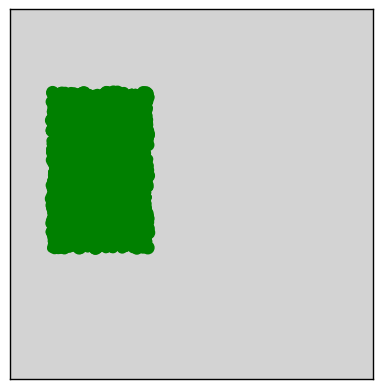

In [13]:
basemap = setup_map(0.1254494017,51.5453117915,0.1288171528,51.5474416113)
def show_year_N_parsloes_park(N):
    xposs, yposs, dbhs, heights = get_data_year_N(N)

    # Scale the DBH values to suitable sizes for plotting
    scaled_dbhs = dbhs * 10  # Adjust this scaling factor as needed
    scaled_heights = heights * 10  # Adjust this scaling factor as needed

    # Setup map and plot trees
    plot_trees(basemap, xposs, yposs, scaled_dbhs)

    plt.show()

show_year_N_parsloes_park(10)

In [ ]:
min_lat, max_lat = agents["lat"].min(), agents["lat"].max()
min_lon, max_lon = agents["lng"].min(), agents["lng"].max()

fig, ax = plt.subplots()
def update(frame):
    # Clear the current plot
    ax.clear()
    # Assume 'data' is a function that retrieves the data for the current frame
    lats, lons, dbhs, heights = get_data_year_N(frame)
    
    x, y = basemap(lons, lats)
    ax.scatter(lats, lons, marker='o', c='green', s=dbhs*5)
    border = 0.001
    # ax.set_xlim(min_lon - border, max_lon + border)
    # ax.set_ylim(min_lat - border, max_lat + border)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"Year: {frame}")

ani = animation.FuncAnimation(fig, update, frames=range(1, 25), repeat=True)
ani.save('parsloes_park_with_regeneration.mp4', writer='ffmpeg')  # Save as video



### 3d :)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

min_lat, max_lat = agents["lat"].min(), agents["lat"].max()
min_lon, max_lon = agents["lng"].min(), agents["lng"].max()

def update_heights(frame):
    # Clear the current plot
    ax.clear()
    # Assume 'data' is a function that retrieves the data for the current frame
    lats, lons, dbhs, heights = get_data_year_N(frame)

    x, y = basemap(lons, lats)
    # Plot each tree as a line
    for i in range(len(x)):
        ax.plot([x.iloc[i], x.iloc[i]], [y[i], y[i]], [0, heights.iloc[i]], marker='_', color='green')

    ax.set_zlim(0, max(heights))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"Year: {frame}")
    
ax.view_init(elev=20., azim=-35)

ani = animation.FuncAnimation(fig, update_heights, frames=range(1, 25), repeat=True)
ani.save('parsloes_park_heights_with_regeneration.mp4', writer='ffmpeg')  # Save as video


In [ ]:

year_1_CVI, canopy_cover_1 = calculate_nth_year_CVI_and_percentage_canopy_cover(agents[agents['Step'] == 1])
print(canopy_cover_1)

print("Cooling effect of Parsloes Park (compared to 30C baseline):")
for i in range(2, 11):
    year_i_CVI, canopy_cover_i = calculate_nth_year_CVI_and_percentage_canopy_cover(agents[agents['Step'] == i])
    print(canopy_cover_i)
    print(canopy_cover_i - canopy_cover_1)
    dCVI = year_i_CVI - year_1_CVI
    print(dCVI.head())
    dCVI = dCVI.mean()
    ddCVI = year_i_CVI.mean() - year_1_CVI.mean()
    print(dCVI)
    cooling_year_i = compute_cooling(dCVI, T=30, species='miyawaki_decidu')
    print("Year {} cooling: {}".format(i, cooling_year_i))